In [1]:
import numpy as np
import pandas as pd
import json
from scipy import optimize
import matplotlib.pyplot as plt
from matplotlib import cm
from datetime import datetime, timedelta
import matplotlib.dates as dates

In [2]:
import uncertainties.unumpy as unp
import uncertainties as unc

In [3]:
import geopandas as gpd

### Functions

In [4]:
def powerlaw(x, amplitude, exponent):
    return amplitude * x**(exponent)

In [5]:
def exponential(x, amplitude, tau):
    return amplitude * np.exp(x/tau)

In [6]:
def gauss(x, amplitude, mean, sigma):
    return amplitude*np.exp(-(x-mean)**2/(2*sigma**2))

### Import

In [7]:
dfr = pd.read_json('../pcm-dpc-COVID-19/dati-json/dpc-covid19-ita-regioni.json')
dfp = pd.read_json('../pcm-dpc-COVID-19/dati-json/dpc-covid19-ita-province.json')
df = pd.read_json('../pcm-dpc-COVID-19/dati-json/dpc-covid19-ita-andamento-nazionale.json')

In [8]:
dfp['data'] = pd.to_datetime(dfp['data'])
dfr['data'] = pd.to_datetime(dfr['data'])
df['data'] = pd.to_datetime(df['data'])

In [9]:
fr = 'italia/Limiti01012018_g/Reg01012018_g/Reg01012018_g_WGS84.shp'
mapr_df = gpd.read_file(fr)

fp = 'italia/Limiti01012018_g/ProvCM01012018_g/ProvCM01012018_g_WGS84.shp'
mapp_df = gpd.read_file(fp)

In [ ]:
dfp = dfp.set_index('denominazione_provincia').join(mapp_df.set_index('DEN_PCM').geometry)
dfr = dfr.set_index('denominazione_regione').join(mapr_df.set_index('DEN_REG').geometry)

# ITALIA

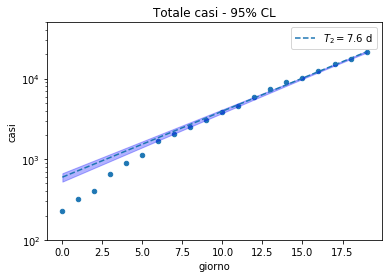

In [13]:
fig, ax = plt.subplots()

x = np.arange(len(df))
px = np.arange(len(df)*2)
dd = 0
last_day = len(df)

df.reset_index().plot.scatter(x='index',y='totale_casi', ax = ax, logy = True, title = 'Totale casi - 95% CL', ylim = [10**2,0.5*10**5])

popt, pcov = optimize.curve_fit(exponential, x[dd:], df.totale_casi[dd:])

y0,tau = unc.correlated_values(popt, pcov)
px = px[:last_day]
py = y0*unp.exp(px/tau)
nom = unp.nominal_values(py)
std = unp.std_devs(py)

ax.fill_between(px, nom + 1.96 * std, nom - 1.96 * std, alpha = 0.3, color = 'blue')

label = r'$T_2=$'+str(round(popt[1]/np.log(2),1))+ r' d'
ax.plot(px[:last_day],exponential(px[:last_day], *popt), ls = '--', label = label)

#ax.scatter(17, exponential(17, *popt), color = 'red')
#ax.scatter(16,12462, color = 'red', label = 'today')

ax.set_xlabel('giorno')
ax.set_ylabel('casi')
ax.legend()
fig.savefig('plot/totale_casi_{}.png'.format(max(df.data).date()), dpi = 300)

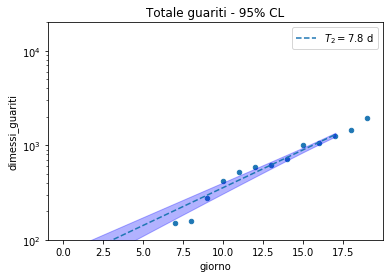

In [14]:
fig, ax = plt.subplots()

x = np.arange(len(df))
px = np.arange(len(df)*2)
dd = 6

df.reset_index().plot.scatter(x='index',y='dimessi_guariti', ax = ax, logy = True, title = 'Totale guariti - 95% CL', ylim=[10**2,2*10**4])

popt, pcov = optimize.curve_fit(exponential, x[dd:], df.dimessi_guariti[dd:])

y0,tau = unc.correlated_values(popt, pcov)
px = px[:18]
py = y0*unp.exp(px/tau)
nom = unp.nominal_values(py)
std = unp.std_devs(py)

ax.fill_between(px, nom + 1.96 * std, nom - 1.96 * std, alpha = 0.3, color = 'blue')

label = r'$T_2=$'+str(round(popt[1]/np.log(2),1))+ r' d'
ax.plot(px[:18],exponential(px[:18], *popt), ls = '--', label = label)

#ax.scatter(17, exponential(17, *popt), color = 'red')
#ax.scatter(16,12462, color = 'red', label = 'today')

ax.set_xlabel('giorno')
ax.legend()
fig.savefig('plot/totale_guariti_{}.png'.format(max(df.data).date()), dpi = 300)

# Province

## Singola Provincia

In [ ]:
provincia = 'LO'

fig, ax = plt.subplots()

x = np.arange(19)
px = np.arange(20)
dd = 1

dfp[dfp.sigla_provincia == provincia].reset_index().reset_index().plot.scatter(x='level_0',y='totale_casi', ax = ax, logy = True, title = 'Totale casi {} - 95% CL'.format(provincia), ylim=[10**2,1.5*10**3])

popt, pcov = optimize.curve_fit(exponential, x[dd:], dfp[dfp.sigla_provincia == provincia].totale_casi[dd:])
y0,tau = unc.correlated_values(popt, pcov)
px = px[:18]
py = y0*unp.exp(px/tau)
nom = unp.nominal_values(py)
std = unp.std_devs(py)

ax.fill_between(px, nom + 1.96 * std, nom - 1.96 * std, alpha = 0.3, color = 'blue')

label = r'$T_2=$'+str(round(popt[1]/np.log(2),1))+ r' d'
ax.plot(px[:18],exponential(px[:18], *popt), ls = '--', label = label)

#poptg, pcovg = optimize.curve_fit(gauss, x[:], dfp[dfp.sigla_provincia == provincia].totale_casi[:], p0=[1000,20,7])
#ax.plot(px[:16],gauss(px[:16], *poptg), ls = '--', label = 'gauss', color = 'red')

#ax.scatter(14, exponential(14, *popt), color = 'red')

ax.set_xlabel('giorno')
ax.legend()
fig.savefig('plot/totale_casi_{}.png'.format(provincia), dpi = 300)

In [ ]:
dfp[dfp.sigla_provincia == provincia].to_csv('pr.csv')

## Analisi Province

In [16]:
province = np.unique(dfp[dfp.sigla_provincia != ''].sigla_provincia.values)
regioni = np.unique(dfp[dfp.denominazione_regione != ''].denominazione_regione.values)

In [17]:
time = max(dfp.loc[:,'data'].values) + pd.Timedelta(days=1) #+ np.timedelta64(1,'D')

df_forecast = dfp[(dfp.data == max(dfp.data.values)) & (dfp.sigla_provincia != '')]
df_forecast.loc[:,'data'] = time
sLength = len(df_forecast['data'])
df_forecast = df_forecast.assign(std = np.zeros(sLength))
#df_forecast.head()

/Users/Emanuele/jupyter_venv/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [18]:
for pr in province:
    df_temp = dfp[dfp.sigla_provincia == pr]
    #df_temp.loc[:,'data'] = pd.to_datetime(df_temp.loc[:,'data'])
    df_temp.loc[:,'data'] = df_temp.loc[:,'data'].apply(lambda x: x.dayofyear)
    #df_temp.loc[:,'data'].apply(lambda x: x.dayofyear)
    
    try:
        x = df_temp[df_temp.totale_casi > 0].data.values - min(df_temp[df_temp.totale_casi > 0].data.values)
        y = df_temp[df_temp.totale_casi > 0].totale_casi.values
        popt, pcov = optimize.curve_fit(exponential, x, y)

        y0,tau = unc.correlated_values(popt, pcov)
        py = y0*unp.exp((max(x)+1)/tau)

        nom = py.nominal_value
        std_new = py.std_dev
    except:
        nom = 0
        std_new = 0
    
    df_forecast.loc[df_forecast.sigla_provincia == pr,['totale_casi','std']] = nom, std_new
    
    

In [41]:
df_forecast.to_csv('forecast_province_2020.03.15.csv')
df_forecast.totale_casi.sum()

25827.573439498792

In [80]:
merged = mapp_df.set_index('DEN_PCM').join(df_forecast.set_index('denominazione_provincia'))
merged['log_totale_casi'] = merged['totale_casi'].apply(lambda x: max(0,np.log10(x)))

In [95]:
merged.head()

,COD_RIP,COD_REG,COD_PROV,COD_CM,COD_PCM,DEN_PROV,DEN_CM,SIGLA,Shape_Leng,Shape_Area,...,stato,codice_regione,denominazione_regione,codice_provincia,sigla_provincia,lat,long,totale_casi,std,log_totale_casi
DEN_PCM,,,,,,,,,,,,,,,,,,,,,
Torino,1,1,1,201,201,-,Torino,TO,539249.812320,6.828137e+09,...,ITA,1.0,Piemonte,1.0,TO,45.073274,7.680687,428.653230,24.565543,2.632106
Vercelli,1,1,2,0,2,Vercelli,-,VC,418249.269903,2.082028e+09,...,ITA,1.0,Piemonte,2.0,VC,45.323981,8.423234,40.869389,2.965587,1.611398
Novara,1,1,3,0,3,Novara,-,NO,250242.386669,1.341320e+09,...,ITA,1.0,Piemonte,3.0,NO,45.445885,8.621916,68.654797,4.425073,1.836671
Cuneo,1,1,4,0,4,Cuneo,-,CN,490111.881760,6.898443e+09,...,ITA,1.0,Piemonte,4.0,CN,44.393296,7.551172,69.720395,4.960584,1.843360
Asti,1,1,5,0,5,Asti,-,AT,315561.373435,1.508948e+09,...,ITA,1.0,Piemonte,5.0,AT,44.899129,8.204143,86.584544,2.380345,1.937440


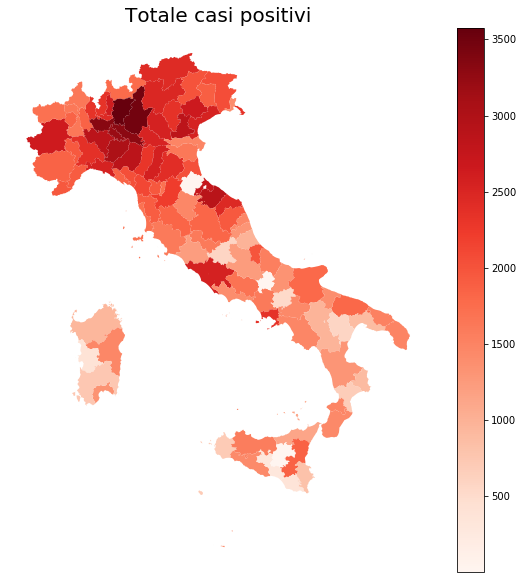

In [63]:
variable = 'log_totale_casi'
vmin, vmax  = min(merged[variable].values), max(merged[variable].values)
fig, ax = plt.subplots(1,figsize=(10,10))

merged.plot(column = variable, cmap = 'Reds', ax = ax);
ax.axis('off')
ax.set_title('Totale casi positivi', fontdict={'fontsize':'20'})
scale = plt.cm.ScalarMappable(cmap ='Reds', norm = plt.Normalize(vmin=10**vmin, vmax=10**vmax))
cbar = fig.colorbar(scale)
plt.savefig('map.png', dpi = 300, bbox_inches = 'tight')

In [20]:
for reg in regioni:
    province = df_forecast[df_forecast.denominazione_regione == reg].denominazione_provincia.values
    if len(province)>4:
        col = 3
    elif len(province)>2:
        col = 2
    else: 
        col = 1
    row = int(len(province)/col) + (len(province)%col > 0) 
    
    fig, axes = plt.subplots(nrows=row, ncols=col, figsize=(12, 12), constrained_layout=True)
    day0, day1 = min(dfp.data.values) - np.timedelta64(1,'D'), max(dfp.data.values) + np.timedelta64(2,'D')

    if len(province)>1:
        for pr, ax in zip(province, axes.flat):
            x = df_forecast[df_forecast.denominazione_provincia == pr].data.values
            y = df_forecast[df_forecast.denominazione_provincia == pr].totale_casi.values
            yerr = 1.96*df_forecast[df_forecast.denominazione_provincia == pr]['std']
            ax.scatter(x,y, color = 'red', s = 30)
            ax.errorbar(x,y,yerr, color = 'red', alpha = 0.9)

            dfp[dfp.denominazione_provincia == pr].plot.scatter(x='data', y='totale_casi', ax = ax, title = pr, xlim =[day0,day1])
            locator = dates.AutoDateLocator(minticks=5, maxticks=7)
            formatter = dates.ConciseDateFormatter(locator)
            ax.xaxis.set_major_locator(locator)
            ax.xaxis.set_major_formatter(formatter)
            ax.set_xlabel('')
            ax.set_ylabel('')
    else:
        x = df_forecast[df_forecast.denominazione_provincia == pr].data.values
        y = df_forecast[df_forecast.denominazione_provincia == pr].totale_casi.values
        yerr = 1.96*df_forecast[df_forecast.denominazione_provincia == pr]['std']
        axes.scatter(x,y, color = 'red', s = 30)
        axes.errorbar(x,y,yerr, color = 'red', alpha = 0.9)

        dfp[dfp.denominazione_provincia == pr].plot.scatter(x='data', y='totale_casi', ax = axes, title = pr, xlim =[day0,day1])
        locator = dates.AutoDateLocator(minticks=5, maxticks=7)
        formatter = dates.ConciseDateFormatter(locator)
        axes.xaxis.set_major_locator(locator)
        axes.xaxis.set_major_formatter(formatter)
        axes.set_xlabel('')
        axes.set_ylabel('')
        
    fig.suptitle('Regione ' + reg, size = 14)
    for i in range(len(province),row*col):
        fig.delaxes(axes.flat[i])
    fig.savefig('plot/Regione_'+reg+'_'+str(max(df.data).date())+'.png', dpi = 200)
    plt.close()

# Regioni

In [53]:
time = max(dfr.loc[:,'data'].values) + pd.Timedelta(days=1) #+ np.timedelta64(1,'D')

dfr_forecast = dfr[(dfr.data == max(dfr.data.values)) & (dfr.denominazione_regione != '')]
dfr_forecast.loc[:,'data'] = time
sLength = len(dfr_forecast)
dfr_forecast = dfr_forecast.assign(std = np.zeros(sLength))
dfr_forecast.head()

/Users/Emanuele/jupyter_venv/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,data,stato,codice_regione,denominazione_regione,lat,long,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_attualmente_positivi,nuovi_attualmente_positivi,dimessi_guariti,deceduti,totale_casi,tamponi,std
399,2020-03-15 17:00:00,ITA,13,Abruzzo,42.351222,13.398438,51,14,65,41,106,23,4,2,112,1232,0.0
400,2020-03-15 17:00:00,ITA,17,Basilicata,40.639471,15.805148,0,2,2,8,10,0,0,0,10,155,0.0
401,2020-03-15 17:00:00,ITA,4,P.A. Bolzano,46.499335,11.356624,26,7,33,137,170,47,0,3,173,1135,0.0
402,2020-03-15 17:00:00,ITA,18,Calabria,38.109228,15.643453,22,4,26,33,59,22,1,0,60,711,0.0
403,2020-03-15 17:00:00,ITA,15,Campania,40.839566,14.250850,72,17,89,154,243,30,23,6,272,1936,0.0


In [129]:
columns = dfr_forecast.columns[6:16]
for col in columns:
    d = {}
    for reg in regioni:
        df_temp = dfr[dfr.denominazione_regione == reg]
        #df_temp.loc[:,'data'] = pd.to_datetime(df_temp.loc[:,'data'])
        df_temp.loc[:,'data'] = df_temp.loc[:,'data'].apply(lambda x: x.dayofyear)
        #df_temp.loc[:,'data'].apply(lambda x: x.dayofyear)
        try:
            x = df_temp[df_temp[col] > 0].data.values - min(df_temp[df_temp[col] > 0].data.values)
            y = df_temp[df_temp[col] > 0].totale_casi.values
            popt, pcov = optimize.curve_fit(exponential, x, y)

            y0,tau = unc.correlated_values(popt, pcov)
            py = y0*unp.exp((max(x)+1)/tau)

            nom = py.nominal_value
            std_new = py.std_dev
        except:
            nom = 0
            std_new = 0
        d[reg] = [nom,std_new]
    dfr_forecast[col] = dfr_forecast.denominazione_regione.apply(lambda x: d[x][0])
    dfr_forecast['std_'+col] = dfr_forecast.denominazione_regione.apply(lambda x: d[x][1])

/Users/Emanuele/jupyter_venv/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/Emanuele/jupyter_venv/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/Users/Emanuele/jupyter_venv/lib/python3.7/site-packages/uncertainties/core.py:178: RuntimeWarning: invalid value encountered in true_divide
  covariance_mat/norm_vector/norm_vector[:,numpy.newaxis],
/Users/Emanuele/jupyter_venv/lib/python3.7/site-packages/uncertainties/core.py:227: RuntimeWarning: invalid value encountered in less
  variances[variances < 0] = 0.


In [65]:
dfr_forecast.to_csv('forecast_regioni_{}.csv'.format(max(dfr_forecast.data).date()))
dfr_forecast.totale_casi.sum()

26315.919969885435

In [133]:
dfr_forecast.loc[dfr_forecast.denominazione_regione == 'Emilia Romagna','denominazione_regione'] = 'Emilia-Romagna'

In [134]:
dfr_forecast

,data,stato,codice_regione,denominazione_regione,lat,long,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,...,std_ricoverati_con_sintomi,std_terapia_intensiva,std_totale_ospedalizzati,std_isolamento_domiciliare,std_totale_attualmente_positivi,std_nuovi_attualmente_positivi,std_dimessi_guariti,std_deceduti,std_totale_casi,std_tamponi
399,2020-03-15 17:00:00,ITA,13,Abruzzo,42.351222,13.398438,156.172821,151.543502,156.172821,153.381733,...,8.846970,21.773453,8.846970,12.211389,8.846970,8.137893,12.558773,21.773453,8.846970,8.084515
400,2020-03-15 17:00:00,ITA,17,Basilicata,40.639471,15.805148,12.121025,11.179563,12.691633,13.453671,...,0.745244,0.901702,0.849062,1.020103,1.020103,0.867808,0.000000,0.000000,1.020103,1.073211
401,2020-03-15 17:00:00,ITA,4,P.A. Bolzano,46.499335,11.356624,262.093125,237.353885,262.093125,258.829418,...,15.599244,18.868229,15.599244,25.617335,15.599244,16.538484,0.000000,28.879721,15.599244,15.145694
402,2020-03-15 17:00:00,ITA,18,Calabria,38.109228,15.643453,83.783255,85.102599,83.783255,83.826820,...,3.871317,6.669326,3.871317,2.952835,2.952835,4.289272,5.540144,0.000000,2.952835,2.606554
403,2020-03-15 17:00:00,ITA,15,Campania,40.839566,14.250850,332.286251,314.456027,332.286251,332.286251,...,9.430195,9.658161,9.430195,9.430195,9.430195,9.419869,9.658161,114.806039,9.430195,9.337856
404,2020-03-15 17:00:00,ITA,8,Emilia-Romagna,44.494367,11.341721,3186.771670,3186.771670,3186.771670,3186.771670,...,95.072210,95.072210,95.072210,95.072210,95.072210,95.072210,65.246328,90.985209,95.072210,95.072210
405,2020-03-15 17:00:00,ITA,6,Friuli Venezia Giulia,45.649435,13.768136,406.411559,402.185592,406.411559,407.167494,...,15.715343,20.508219,15.715343,14.347559,14.347559,14.003711,18.874157,22.664758,14.347559,12.176521
406,2020-03-15 17:00:00,ITA,12,Lazio,41.892770,12.483667,453.446671,448.821762,453.446671,452.031788,...,12.232227,13.081033,12.232227,13.994432,12.232227,12.925096,11.277643,16.537652,11.277643,11.277643
407,2020-03-15 17:00:00,ITA,7,Liguria,44.411493,8.932699,620.261361,622.483729,620.261361,620.199012,...,17.718543,18.486789,17.718543,18.258507,17.718543,18.677308,18.486789,11.184224,17.718543,17.230689
408,2020-03-15 17:00:00,ITA,3,Lombardia,45.466794,9.190347,14444.297101,14444.297101,14444.297101,14444.297101,...,282.977218,282.977218,282.977218,282.977218,282.977218,291.276476,289.840713,282.977218,282.977218,282.977218


In [135]:
mergedr = mapr_df.set_index('DEN_REG').join(dfr_forecast.set_index('denominazione_regione'))

In [136]:
mergedr = pd.concat([mergedr, merged[merged.DEN_PROV == 'Trento']])
mergedr = pd.concat([mergedr, merged[merged.DEN_PROV == 'Bolzano']])
mergedr.totale_casi.tail()
#mergedr.append(merged.loc['Trento'])

Calabria     83.826820
Sicilia     201.948258
Sardegna     67.446258
Trento      303.761538
Bolzano     262.093125
Name: totale_casi, dtype: float64

[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4. ]


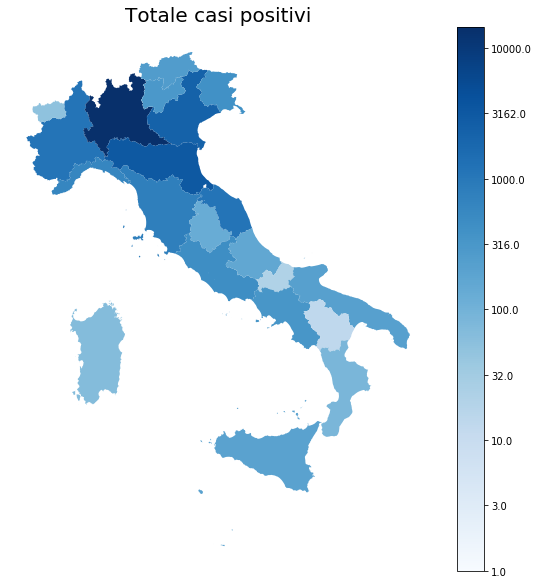

In [142]:
mergedr['log_totale_casi'] = mergedr['totale_casi'].apply(lambda x: max(0,np.log10(x)))
variable = 'log_totale_casi'
vmin, vmax  = min(mergedr[variable].values), max(mergedr[variable].values)
fig, ax = plt.subplots(1,figsize=(10,10))

mergedr.plot(column = variable, cmap = 'Blues', ax = ax, legend = True);
ax.axis('off')
ax.set_title('Totale casi positivi', fontdict={'fontsize':'20'})
#scale = plt.cm.ScalarMappable(cmap ='Blues', norm = plt.Normalize(vmin=vmin, vmax=vmax))
#cbar = fig.colorbar(scale)

colourbar = ax.get_figure().get_axes()[1]

# Get numerical values of yticks, assuming a linear range between vmin and vmax:
yticks = colourbar.get_yticks()
#yticks = np.interp(colourbar.get_yticks(), [0,1], [vmin, vmax])
print(yticks)

# Apply some function f to each tick, where f can be your percentage conversion
colourbar.set_yticklabels([round(10**ytick) for ytick in yticks])
plt.savefig('map_regioni{}.png'.format(max(dfr_forecast.data).date()), dpi = 300, bbox_inches = 'tight')